In [1]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from data_normalizer import unscale_data_with_minmax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

In [2]:
# uncomment to train model locally
# import subprocess
# subprocess.run("python train_model.py", shell=True)

In [3]:
filtered_data = np.load('./macroeconomic_data/filtered_data.npy', allow_pickle=True).item()

data = []
for date, data_frame in filtered_data.items():
    flattened_data = pd.json_normalize(data_frame, sep=".")
    flattened_data["10"] = str(date[1])
    data.append(flattened_data)
data = pd.concat(data, ignore_index=True)

X = data
X = X.iloc[:-1, :]
y = data.filter(regex='0.36', axis=1)
y = y.iloc[1:]
y = y.values.ravel()

best_estimator = joblib.load('./joblib/best_estimator.joblib')
print(best_estimator)
random_state = np.random.RandomState()
random_state.set_state(joblib.load('./joblib/split_random_state.joblib'))
print(random_state)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

MLPRegressor(activation='tanh', alpha=5e-05,
             hidden_layer_sizes=(200, 200, 200, 200), learning_rate='adaptive',
             max_iter=100000, momentum=0.85, solver='sgd', tol=1e-06)
RandomState(MT19937)


In [4]:
y_pred = best_estimator.predict(X_test)
y_pred_scaled = unscale_data_with_minmax(np.array(y_pred))
y_test_scaled = unscale_data_with_minmax(np.array(y_test))

print("Predicted\t\tActual")
for pred, actual in zip(y_pred_scaled, y_test_scaled):
    print(f"{pred}\t\t{actual}")

Predicted		Actual
99.85809289801087		100.3
99.86600431790798		100.0
100.14447066445942		99.9
99.89738723991		99.8
99.99697130535769		100.1
100.90753259353738		101.8
100.27820404641102		100.8
99.87505477467039		100.2
100.05910428932435		99.7
100.90129278960076		101.5
100.20539146303521		100.4
99.87734284792845		99.9
100.01366942913116		99.8
100.01848919151938		99.8
99.52080482686313		99.7
100.24193272955776		100.7
101.03004377422454		100.9
99.92168383319375		100.0
100.84770546142553		100.3
100.96320446360953		100.7
100.70552856319478		100.7
100.01089654865854		100.0
100.00575468515058		100.2
99.84160083419525		100.2
100.79764411075199		100.3
100.04322521334755		100.2
100.58182701733595		100.4
100.12210293343905		100.1
99.87335504663855		100.1
99.99227951064249		100.7
100.5813909544246		101.1
99.85078427415709		99.8
100.2179037607743		100.2
100.49001149331421		99.8
100.70893275360326		100.5
100.86217510631998		100.7
100.39941696946126		99.5
99.87231511330013		99.8
99.88800572694818		100.

In [5]:
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
r2 = r2_score(y_test_scaled, y_pred_scaled)
print('Mean Squared Error:', mse)
print('R-squared Score:', r2)

Mean Squared Error: 0.13820193754835708
R-squared Score: 0.43138620695993546


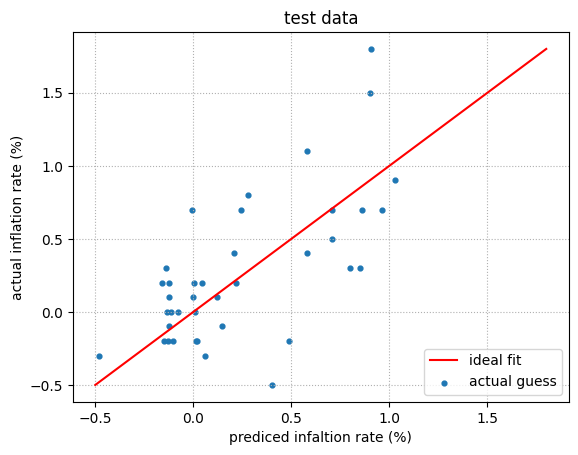

In [6]:
low_test_bound = np.min([*y_pred_scaled,*y_test_scaled])-100
high_test_bound = np.max([*y_pred_scaled,*y_test_scaled])-100

plt.figure()
plt.grid(linestyle=':')
plt.plot([low_test_bound, high_test_bound], [low_test_bound, high_test_bound], c='r', label="ideal fit")
plt.scatter(y_pred_scaled-100, y_test_scaled-100, s=12, label="actual guess")
plt.legend(loc='lower right')
plt.xlabel('prediced infaltion rate (%)')
plt.ylabel('actual inflation rate (%)')
plt.title("test data")
plt.show()

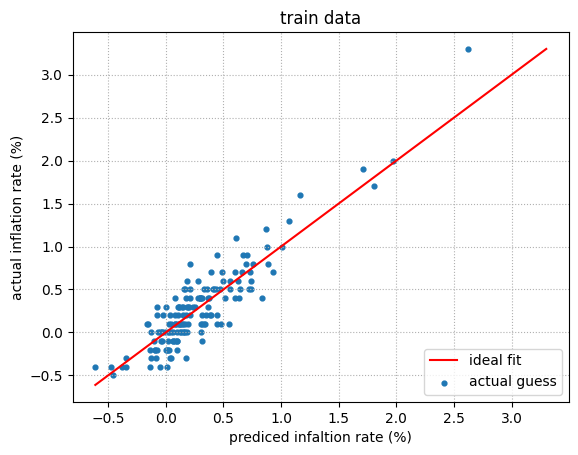

In [7]:
y_train_scaled = unscale_data_with_minmax(y_train)
y_train_pred = unscale_data_with_minmax(best_estimator.predict(X_train))
low_train_bound = np.min([*y_train_scaled,*y_train_pred])-100
high_train_bound = np.max([*y_train_scaled,*y_train_pred])-100

plt.figure()
plt.grid(linestyle=':')
plt.plot([low_train_bound, high_train_bound], [low_train_bound, high_train_bound], c='r', label="ideal fit")
plt.scatter(y_train_pred-100, y_train_scaled-100, s=12, label="actual guess")
plt.legend(loc='lower right')
plt.xlabel('prediced infaltion rate (%)')
plt.ylabel('actual inflation rate (%)')
plt.title("train data")
plt.show()

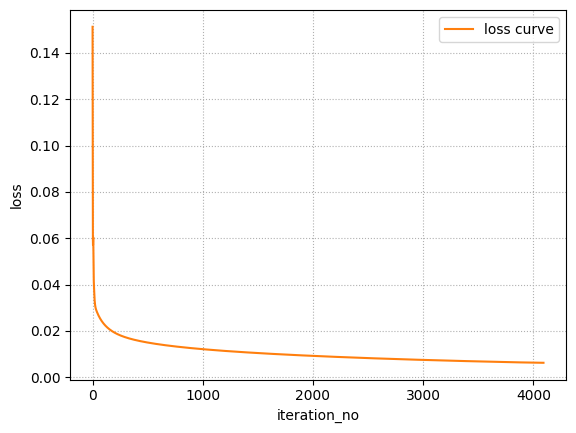

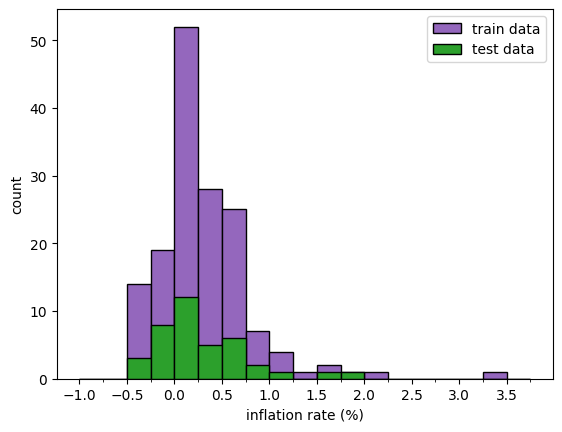

In [8]:
plt.figure()
plt.plot(best_estimator.loss_curve_, color='tab:orange', label="loss curve")
plt.legend()
plt.xlabel("iteration_no")
plt.ylabel("loss")
plt.grid(linestyle=':')
plt.show()

x_ticks = np.arange(-1,4,0.25)
plt.figure()
plt.hist(y_train_scaled-100, x_ticks, edgecolor='black', label="train data", color='tab:purple')
plt.hist(y_test_scaled-100, x_ticks, edgecolor='black', label="test data", color='tab:green')
plt.xticks(np.arange(-1,4,0.5))
plt.xticks(x_ticks, minor=True)
plt.legend()
plt.xlabel("inflation rate (%)")
plt.ylabel("count")
plt.show()

In [9]:
filtered_data_recent = np.load('./macroeconomic_data/filtered_data_recent.npy', allow_pickle=True).item()
normalized_data_recent = np.load('./macroeconomic_data/normalized_data_recent.npy', allow_pickle=True).item()

data_recent = []
for date, data_frame in filtered_data_recent.items():
    flattened_data = pd.json_normalize(data_frame, sep=".")
    flattened_data["10"] = str(date[1])
    data_recent.append(flattened_data)

data_recent = pd.concat(data_recent, ignore_index=True)
X_recent = data_recent

y_recent = []
for date, data_frame in normalized_data_recent.items():
    if 0 in data_frame:
        if 36 in data_frame[0]:
            if data_frame[0][36] is not None:
                y_recent.append(data_frame[0][36])

if len(y_recent) > len(X_recent):
    y_recent = y_recent[1:len(X_recent) + 1]
else:
    X_recent = X_recent.iloc[:-1, :]
    y_recent = data_recent.filter(regex='0.36', axis=1)
    y_recent = y_recent.iloc[1:]
    y_recent = y_recent.values.ravel()


y_recent_pred = best_estimator.predict(X_recent)

y_recent_scaled = unscale_data_with_minmax(np.array(y_recent))
y_recent_pred_scaled = unscale_data_with_minmax(y_recent_pred)

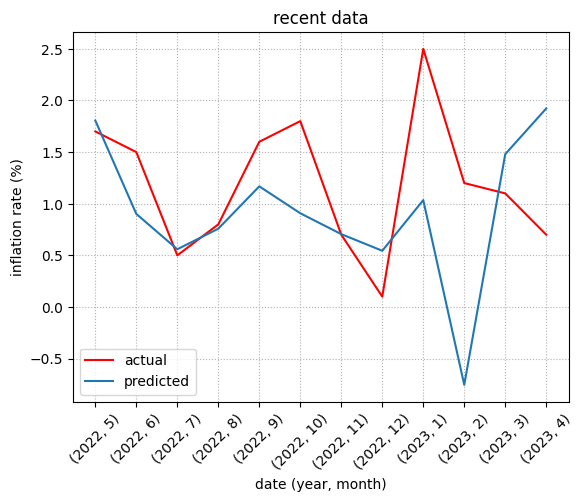

In [10]:
number_of_months = 12
actual_data = y_recent_scaled[-number_of_months:]-100
predicted_data = y_recent_pred_scaled[-number_of_months:]-100
xticks_labels = [(date[0], date[1]+1) if date[1]+1 <= 12 else (date[0]+1, 1)
                 for date in list(filtered_data_recent.keys())[-12:]]

plt.figure()
plt.grid(linestyle=':')
plt.plot(actual_data, label="actual", c='r')
plt.plot(predicted_data, label="predicted")
plt.legend(loc='lower left')
plt.xticks(range(number_of_months), xticks_labels, rotation=45)
plt.xlabel('date (year, month)')
plt.ylabel('inflation rate (%)')
plt.title('recent data')
plt.show()